# Handwritten text recognition

In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # find automatically the path of the folder containing "file_name" :
    file_name = 'ann_solution.ipynb'
    import subprocess
    # path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    # path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    # if previous search failed or too long, comment the previous line and simply write down manually the path below :
    path_to_file = '/content/gdrive/My Drive/CS5242 Project/Solutions/ANN Solution/'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/CS5242 Project/ANN Solution/
/content/gdrive/.shortcut-targets-by-id/1fYoPc4cTre2OE-DPuGBLLQYb7zuw8sxY/CS5242 Project/ANN Solution


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import os
import time

### Choose GPU

In [ ]:
device= torch.device("cuda")
# device= torch.device("cpu")
print(device)

cuda


In [ ]:
import numpy as np
import utils

### Prepare the dataset

In [ ]:
train_data_folder = '../../ready_data/2/'

train_data_file = train_data_folder + 'data.pt'
train_labels_file = train_data_folder + 'labels.pt'

train_data = 1 - torch.load(train_data_file) / 255
train_labels = torch.load(train_labels_file)


test_data_folder = '../../ready_data/1/'

test_data_file = test_data_folder + 'data.pt'
test_labels_file = test_data_folder + 'labels.pt'

test_data = 1 - torch.load(test_data_file) / 255
test_labels = torch.load(test_labels_file)



In [ ]:
from torchvision import transforms

train_transform = transforms.Compose(
                    [
                    transforms.ToPILImage(),
                    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor(),
                    ])

augmented_images = []
augmented_labels = []

for tensor, label in zip(train_data, train_labels):
    for i in range(20):
        new_image = train_transform(tensor)
        augmented_images.append(new_image)
        augmented_labels.append(label)

train_augmented_data = torch.stack(augmented_images)
train_augmented_labels = torch.stack(augmented_labels)


In [ ]:
train_augmented_data.shape

torch.Size([21880, 1, 64, 64])

### Make a convnet-based class. 

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = torch.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=True):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial = no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()

    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

class ConvPart(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1a = nn.Conv2d(1, 64, 5, padding=2)
        self.p1 = nn.MaxPool2d(2)
        self.c2a = nn.Conv2d(64, 64, 5, padding=2)
        self.p2 = nn.MaxPool2d(2)
        self.c3 = nn.Conv2d(64, 64, 5, padding=2)
        self.bn1a = nn.BatchNorm2d(64)
        self.bn2a = nn.BatchNorm2d(64)

    def forward(self, x):
        z = self.bn1a(F.leaky_relu(self.c1a(x)))
        z = self.p1(z)
        z = self.bn2a(F.leaky_relu(self.c2a(z)))
        z = self.p2(z)
        z = self.c3(z)
        return z

class NetCBAM(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = ConvPart()
        self.attn1 = CBAM(gate_channels=64, no_spatial=False)
        self.final = nn.Linear(64, 48)

    def forward(self, x):
        z = self.conv(x)
        q = self.attn1(z)
        z = q.mean(3).mean(2)
        p = self.final(z)
        return p

### Build the net. How many parameters in total?

In [ ]:
net=NetCBAM()
print(net)
utils.display_num_param(net)

NetCBAM(
  (conv): ConvPart(
    (c1a): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (c2a): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (p2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (c3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (attn1): CBAM(
    (ChannelGate): ChannelGate(
      (mlp): Sequential(
        (0): Flatten()
        (1): Linear(in_features=64, out_features=4, bias=True)
        (2): ReLU()
        (3): Linear(in_features=4, out_features=64, bias=True)
      )
    )
  )
  (final): Linear(in_features=64, out_features=48, bias=True)
)
There are 210548 (0.21 million) parameters in this neural n

### Send the weights of the networks to the GPU (as well as the mean and std)

In [ ]:
net = net.to(device)

### Choose the criterion, learning rate, and batch size.

In [ ]:
criterion = nn.CrossEntropyLoss()

my_lr=0.02

bs= 100

### Function to evaluate the network on the test set

In [ ]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    minibatch_data =  test_data.unsqueeze(dim=1)
    minibatch_label= test_labels

    minibatch_data=minibatch_data.to(device)
    minibatch_label=minibatch_label.to(device)
    
    scores =net( minibatch_data )

    probs= F.softmax(scores, dim=1)

    error = utils.get_error( probs , minibatch_label)

    print( 'error rate on test set =', error*100 ,'percent')

### Do 30 passes through the training set. Divide the learning rate by 2 every 5 epochs.

In [ ]:
start=time.time()

N = train_augmented_data.shape[0]

for epoch in range(15):
    
    if not epoch%5:
        my_lr = my_lr / 1.5
        
    optimizer=torch.optim.Adam(net.parameters(), lr=my_lr)
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(N)
 
    for count in range(0,N,bs):
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
             
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_augmented_data[indices]
        minibatch_label=  train_augmented_labels[indices]
        
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        minibatch_data.requires_grad_()

        scores=net( minibatch_data )
        
        loss =  criterion( scores, minibatch_label)
          
        loss.backward()
        
        optimizer.step()
        

        # COMPUTE STATS
        
        running_loss += loss.detach().item()
        
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_test_set() 
    print(' ')
    
    

epoch= 0 	 time= 0.35120580196380613 min 	 lr= 0.013333333333333334 	 loss= 2.6004336849195226 	 error= 71.23287733831361 percent
error rate on test set = 64.50216486340477 percent
 
epoch= 1 	 time= 0.7037596146265666 min 	 lr= 0.013333333333333334 	 loss= 1.0334316021231211 	 error= 32.60274123927774 percent
error rate on test set = 52.16450397070352 percent
 
epoch= 2 	 time= 1.054831858476003 min 	 lr= 0.013333333333333334 	 loss= 0.6515711815389869 	 error= 20.92123483413975 percent
error rate on test set = 53.46320274072293 percent
 
epoch= 3 	 time= 1.4058528264363608 min 	 lr= 0.013333333333333334 	 loss= 0.531392661676015 	 error= 17.05365502126685 percent
error rate on test set = 50.21645050028186 percent
 
epoch= 4 	 time= 1.7578971306482951 min 	 lr= 0.013333333333333334 	 loss= 0.41707415919597834 	 error= 13.16666858925667 percent
error rate on test set = 51.73160395064911 percent
 
epoch= 5 	 time= 2.109281861782074 min 	 lr= 0.008888888888888889 	 loss= 0.26007231964504

### Choose image at random from the test set and see how good/bad are the predictions

In [ ]:
label = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Epsilon', 'Zeta', 'Eta', 'Theta', 'Iota', 'Kappa', 'Lambda', 'Mu', 'Nu', 'Xi', 'Omicron', 'Pi', 'Rho', 'Sigma', 'Tau', 'Upsilon', 'Phi', 'Chi', 'Psi', 'Omega', 'alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta', 'eta', 'theta', 'iota', 'kappa', 'lambda', 'mu', 'nu', 'xi', 'omicron', 'pi', 'rho', 'sigma', 'tau', 'upsilon', 'phi', 'chi', 'psi', 'omega']

tensor(0.5900)


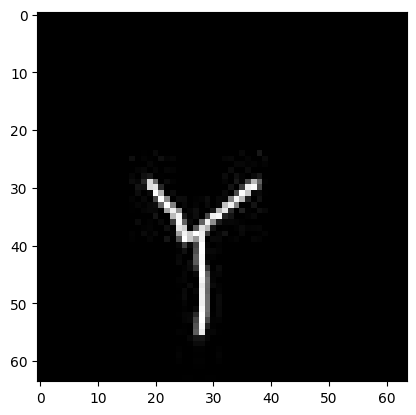

Upsilon


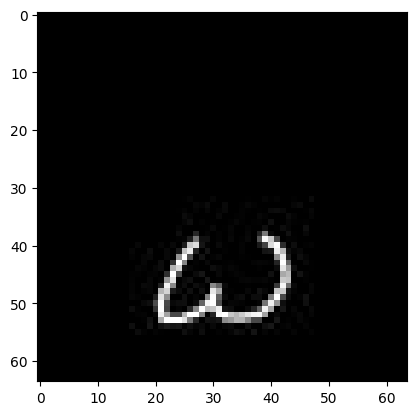

omega


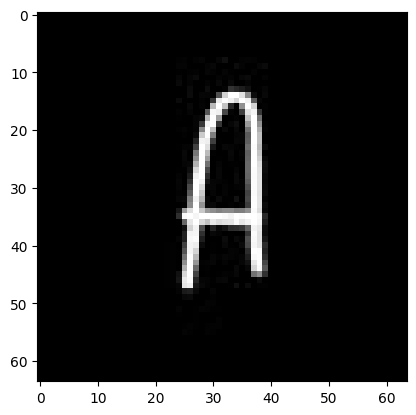

eta


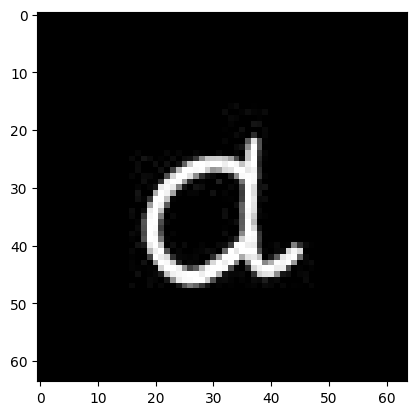

alpha


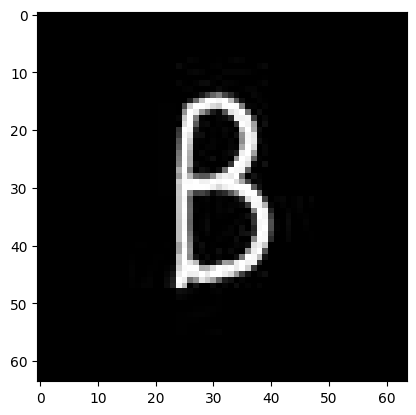

Beta


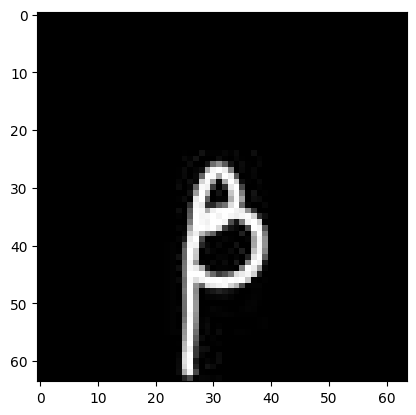

rho


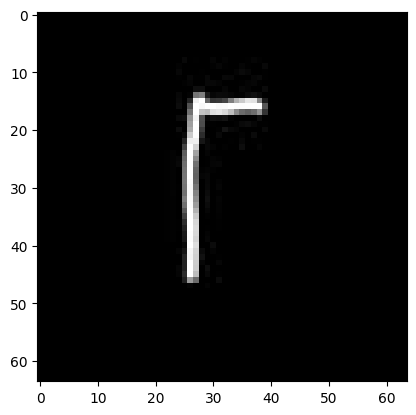

Gamma


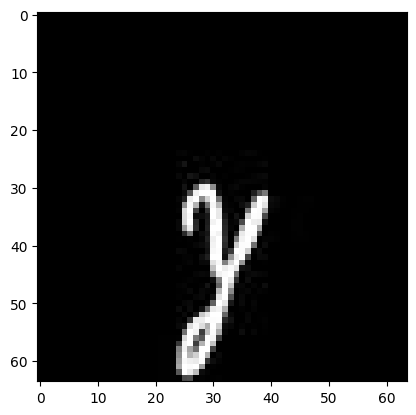

psi


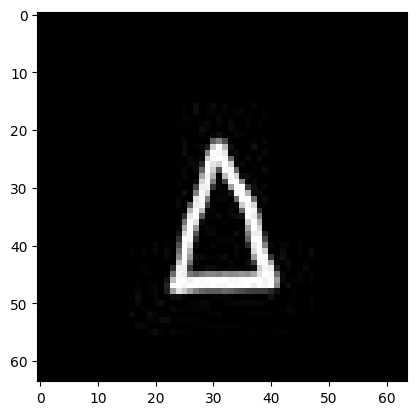

Delta


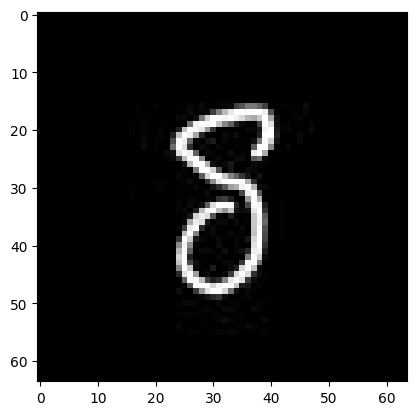

delta


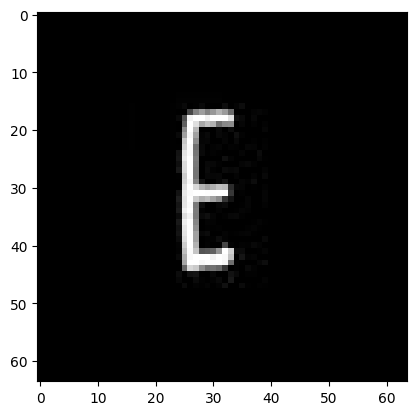

epsilon


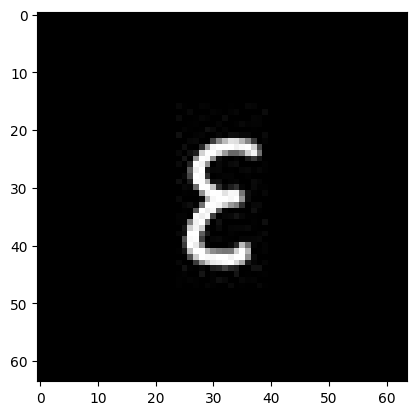

epsilon


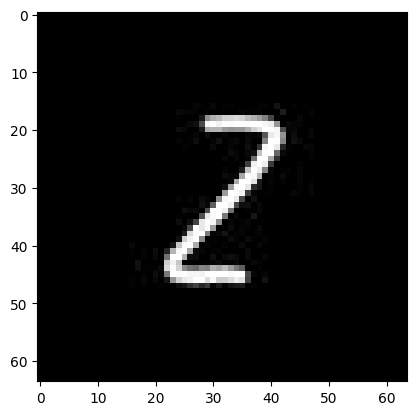

zeta


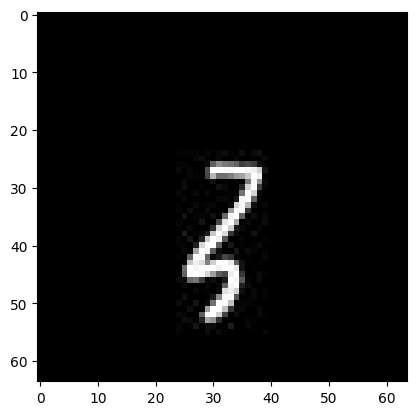

zeta


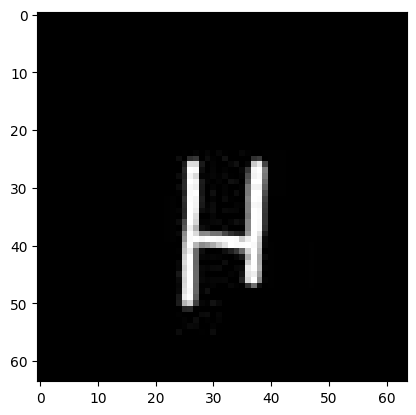

kappa


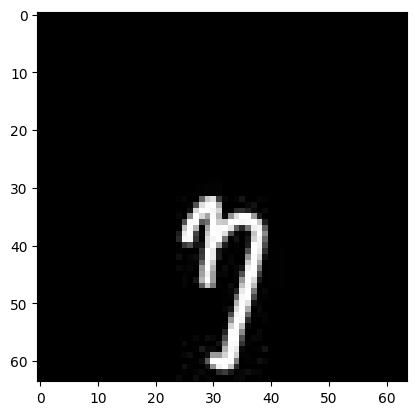

xi


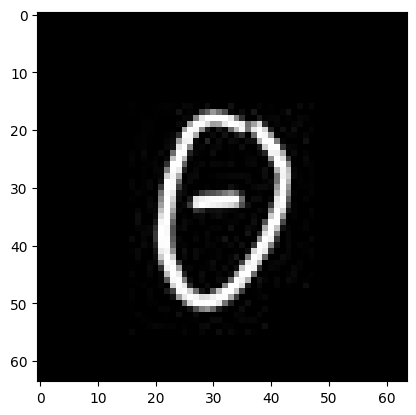

Theta


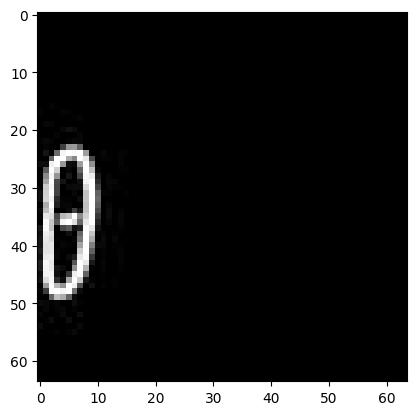

rho


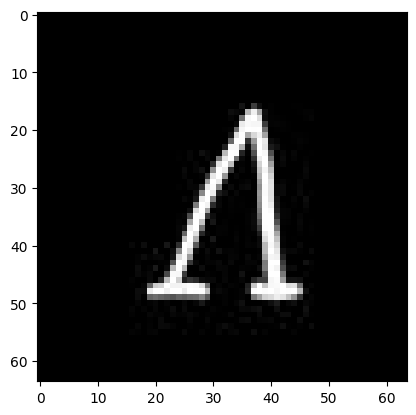

Delta


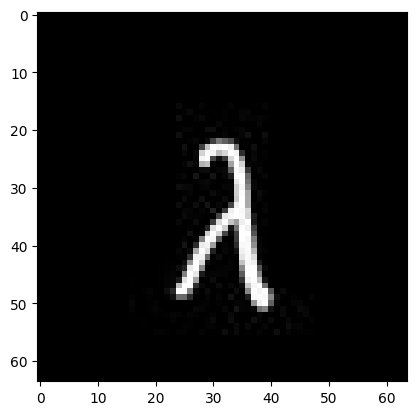

lambda


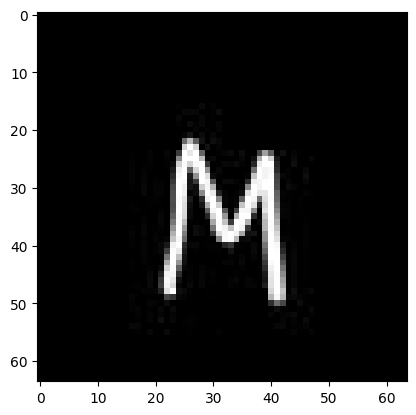

Mu


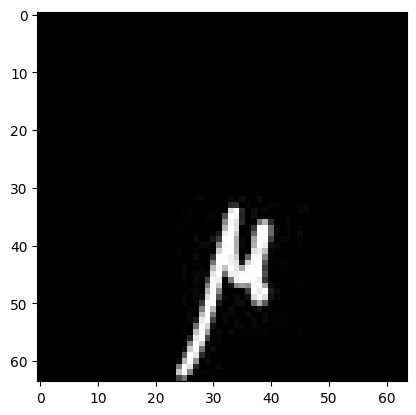

mu


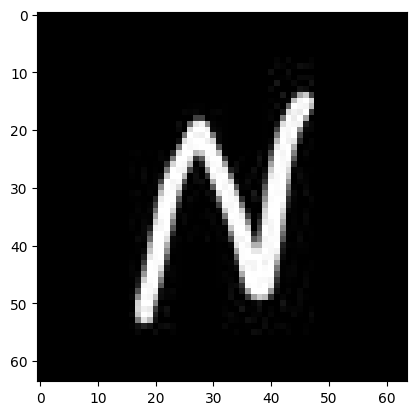

Nu


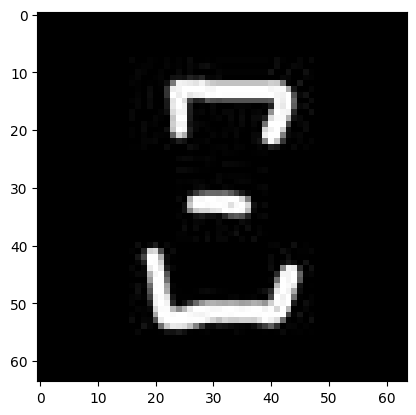

Xi


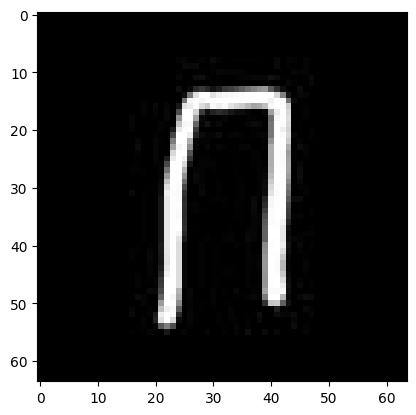

Pi


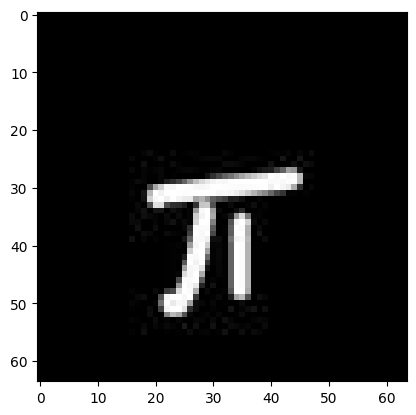

pi


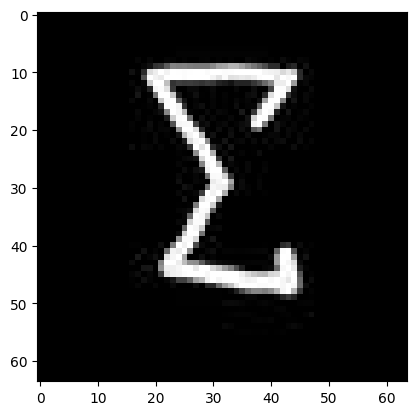

Sigma


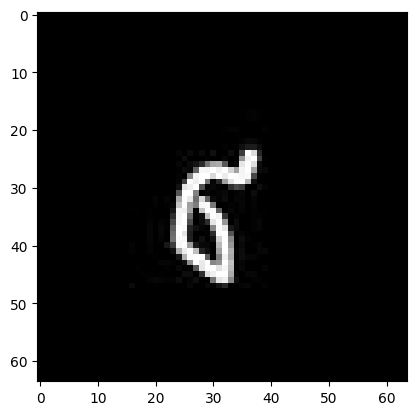

delta


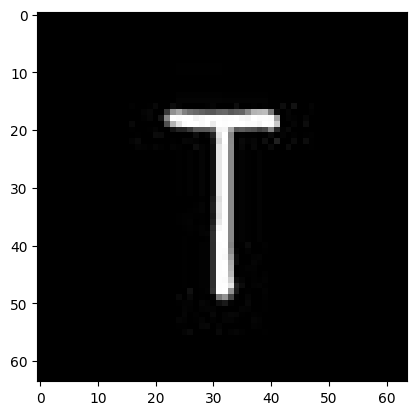

tau


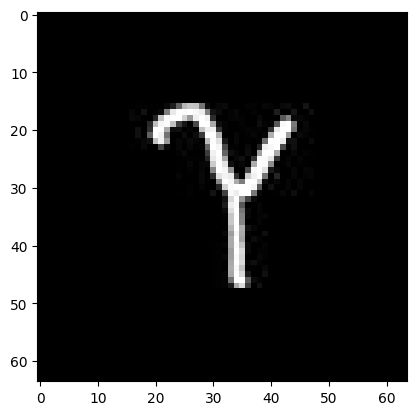

upsilon


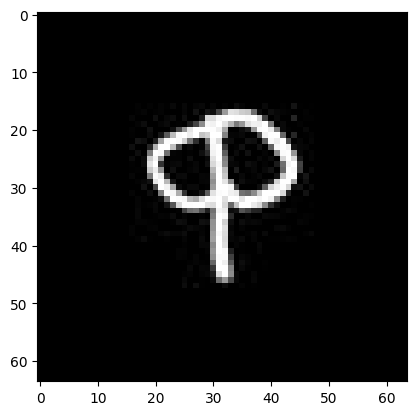

Phi


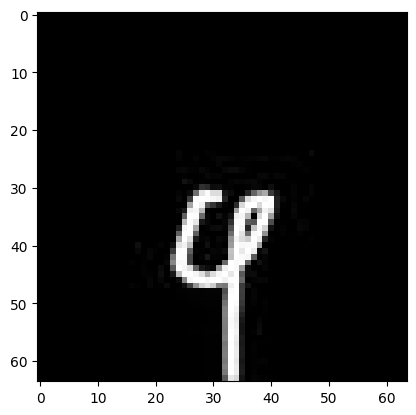

phi


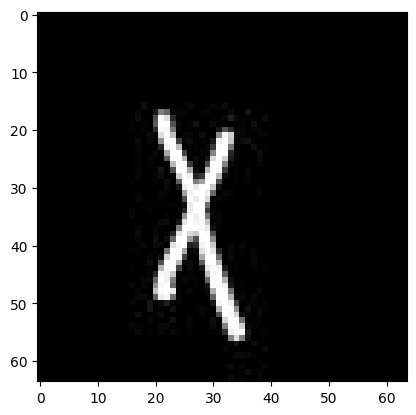

Chi


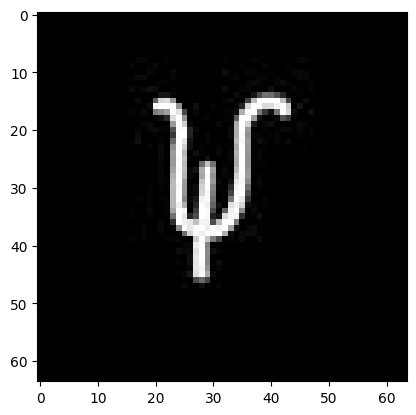

Psi


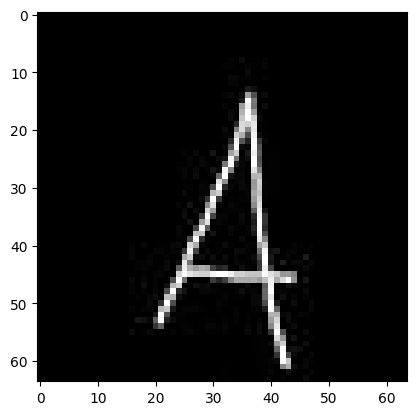

Alpha


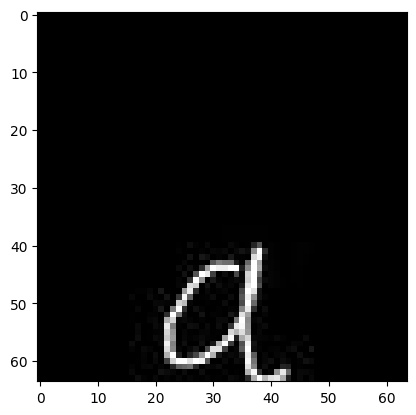

alpha


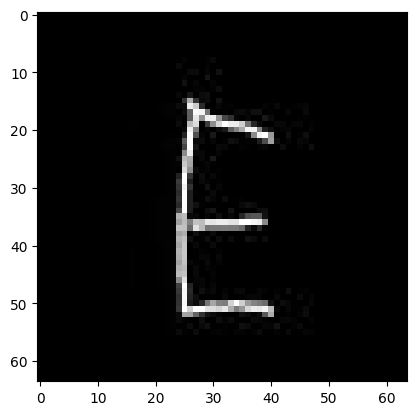

Epsilon


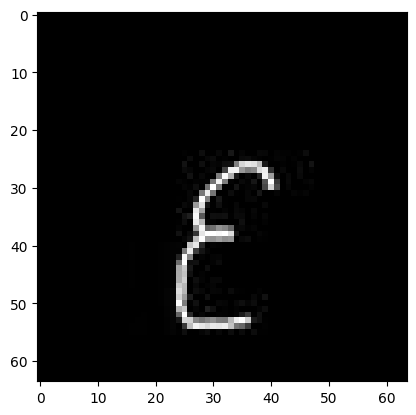

epsilon


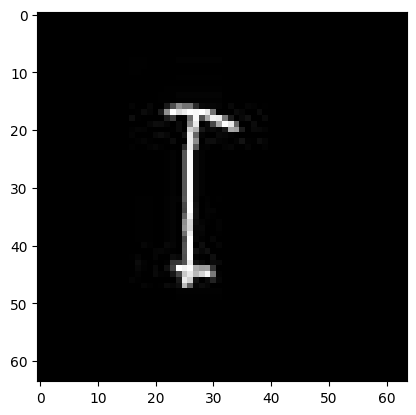

Iota


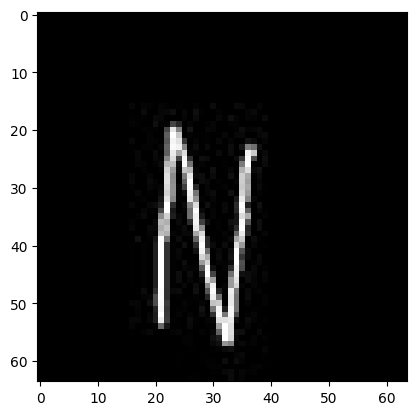

Nu


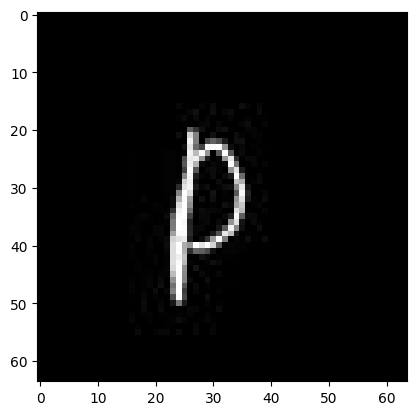

Rho


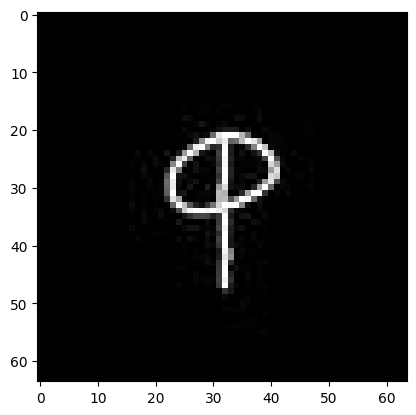

theta


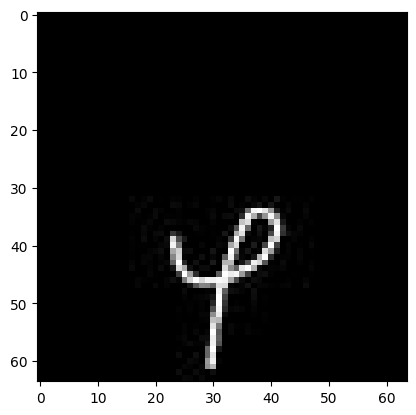

psi


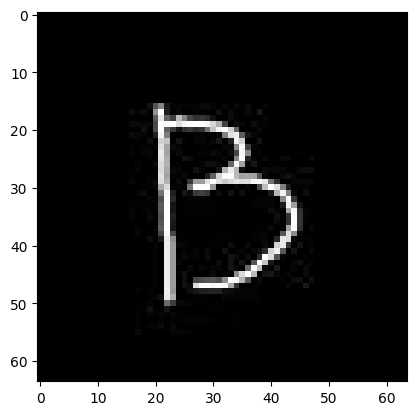

Beta


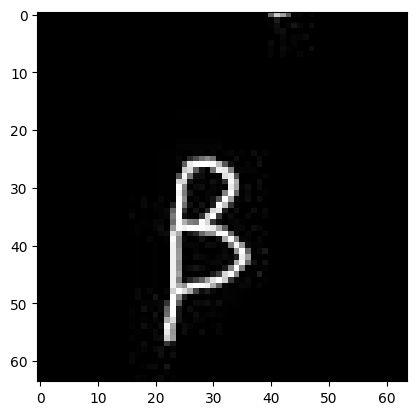

beta


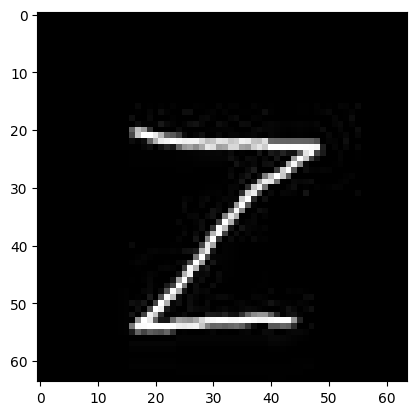

Zeta


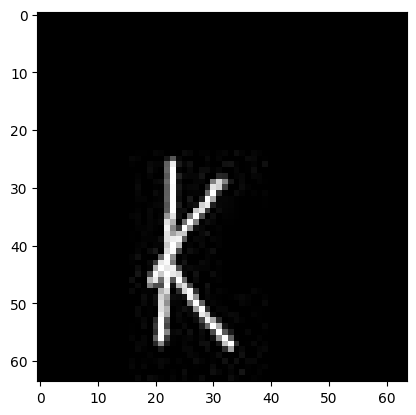

Kappa


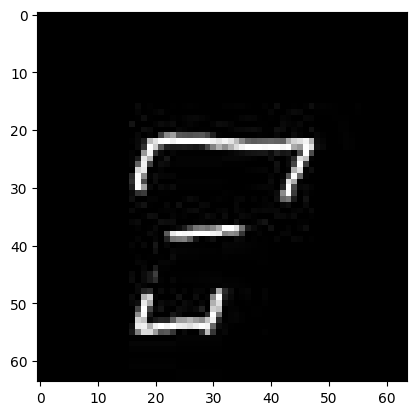

Xi


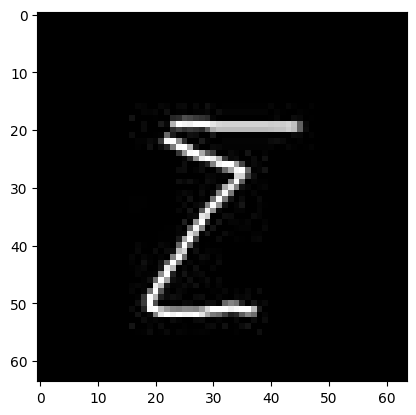

Sigma


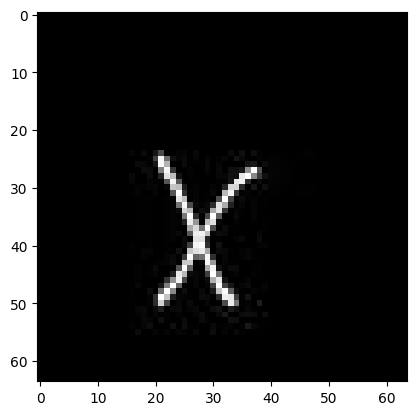

Chi


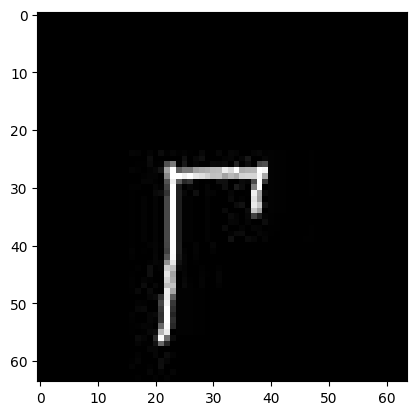

Gamma


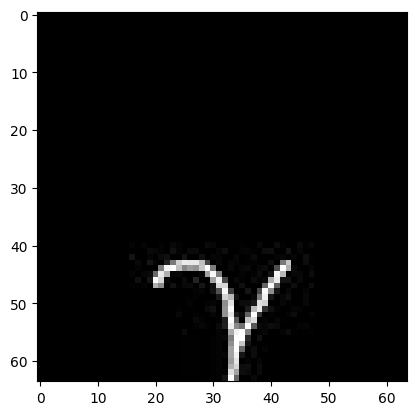

chi


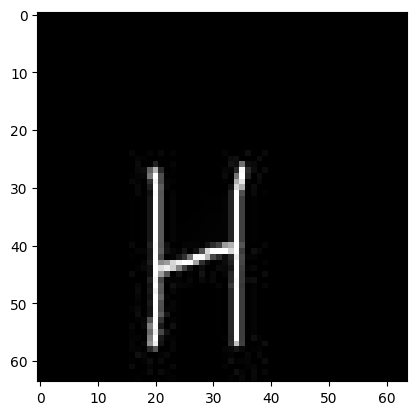

Eta


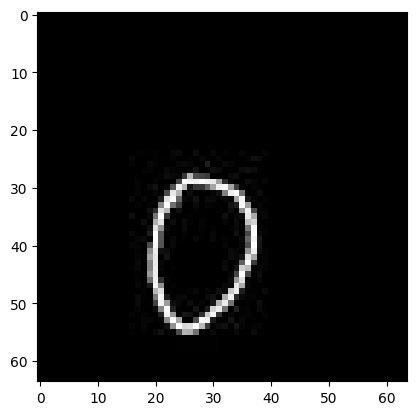

Theta


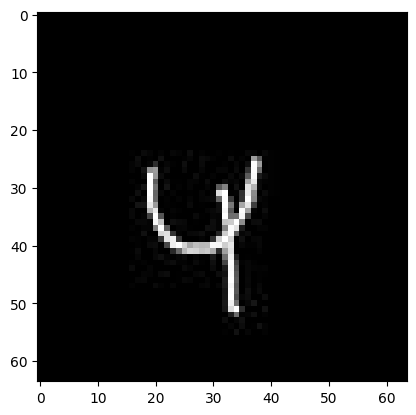

psi


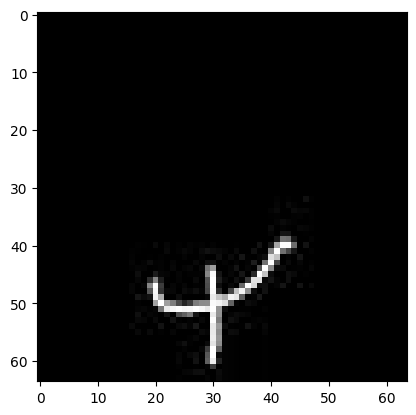

psi


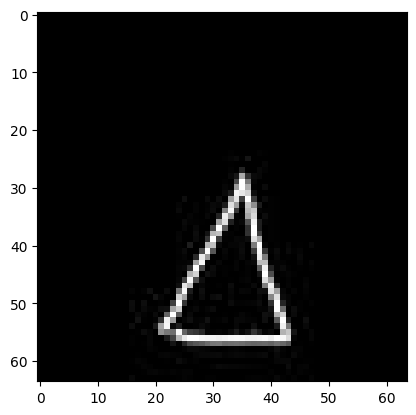

Delta


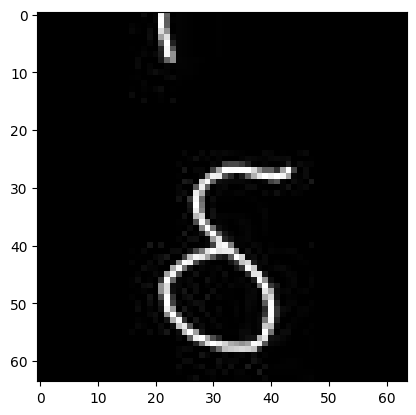

delta


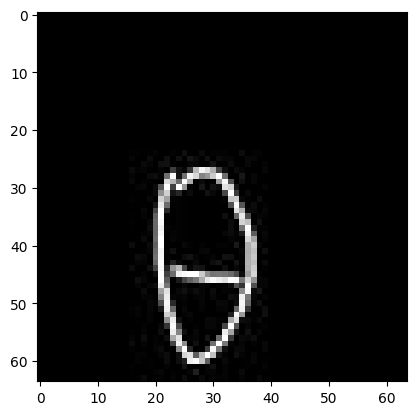

Phi


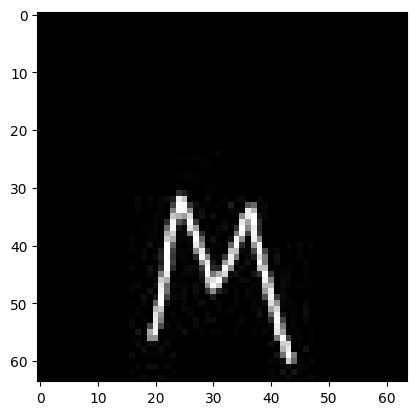

Mu


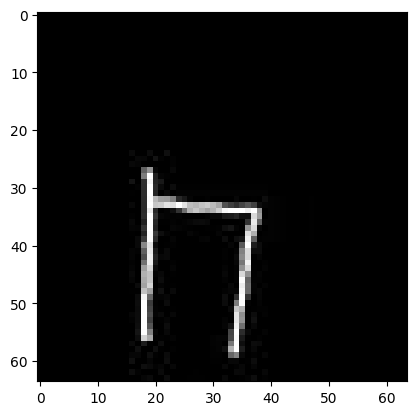

eta


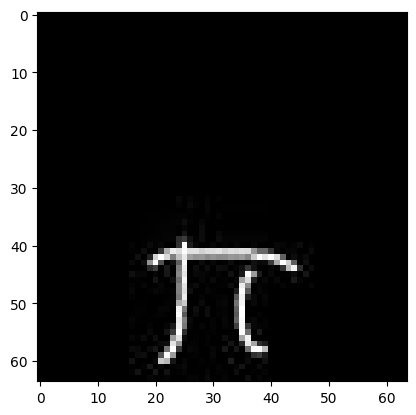

pi


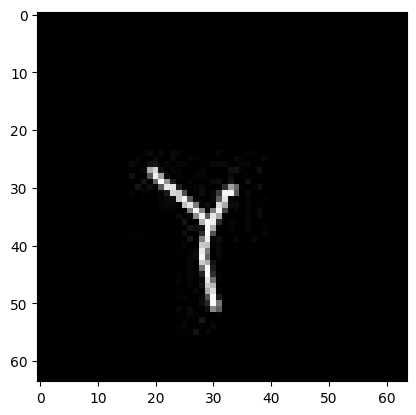

Upsilon


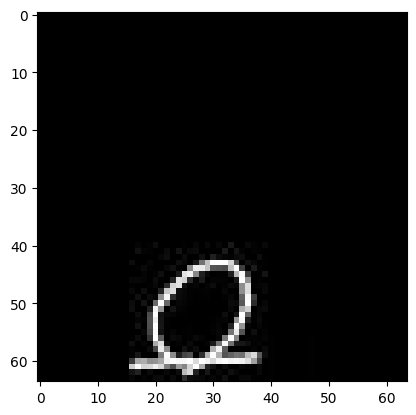

Omega


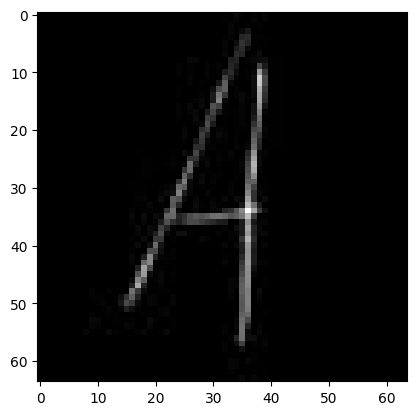

Chi


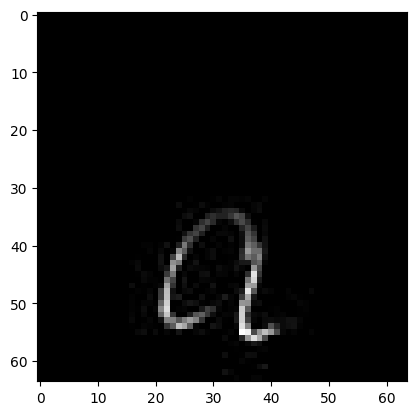

iota


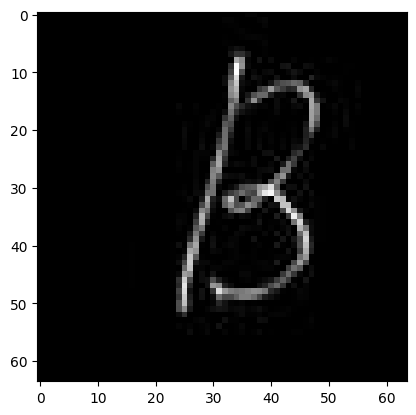

Kappa


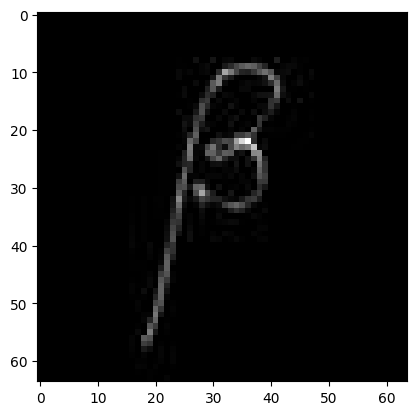

Delta


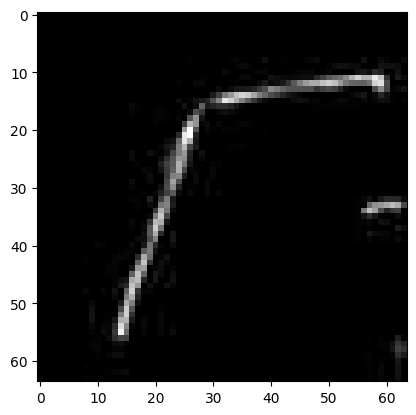

Tau


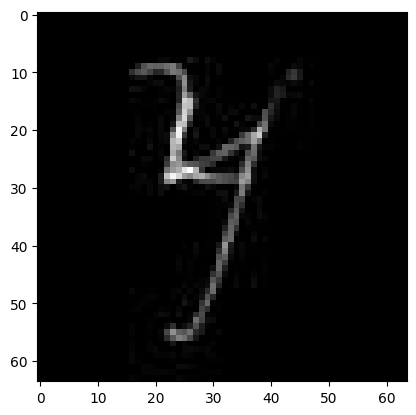

Chi


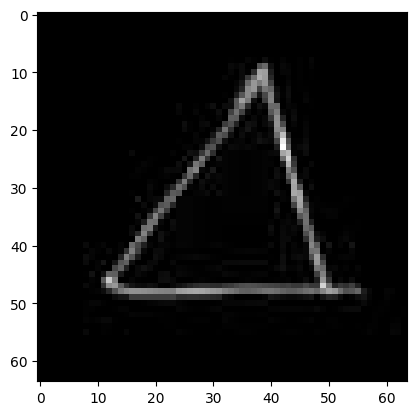

Delta


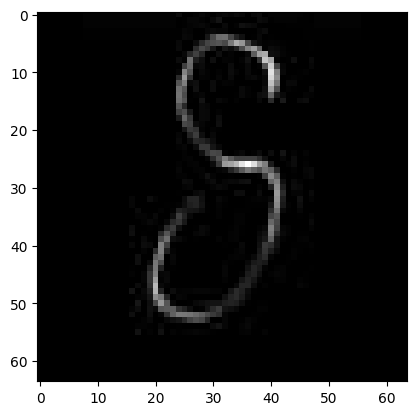

zeta


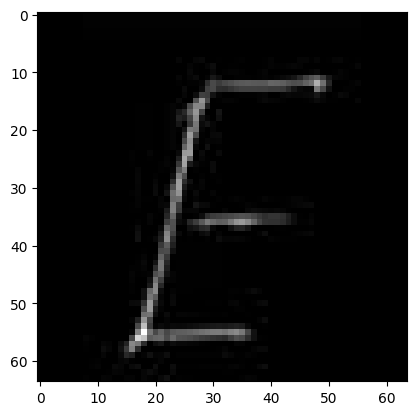

Epsilon


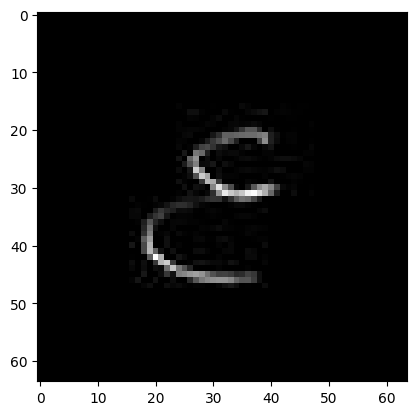

omega


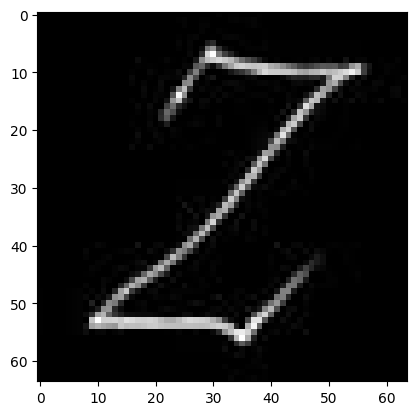

Chi


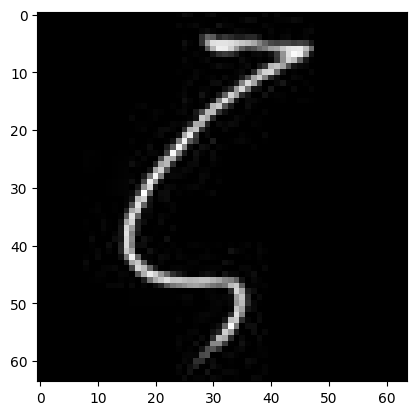

Gamma


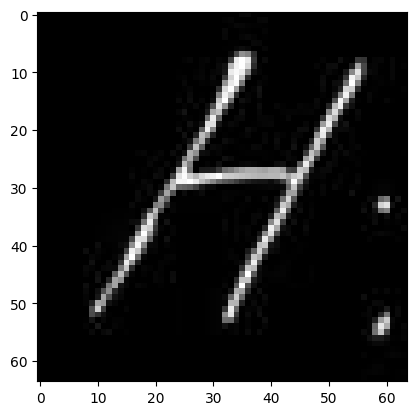

Chi


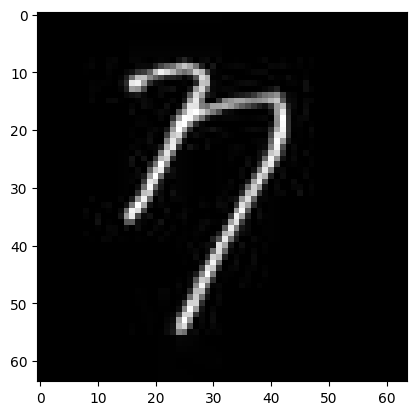

zeta


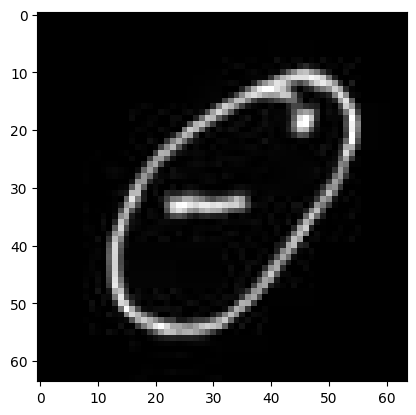

Theta


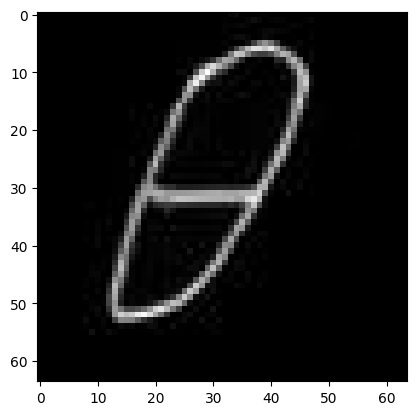

Gamma


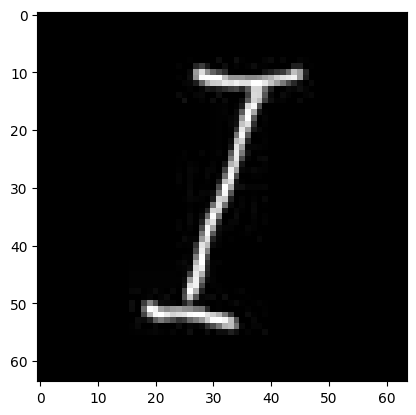

Iota


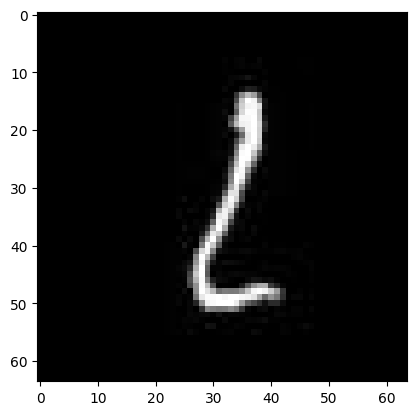

iota


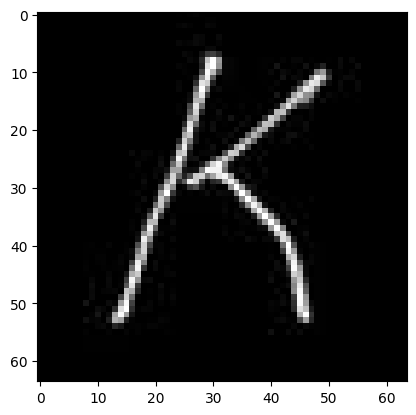

Kappa


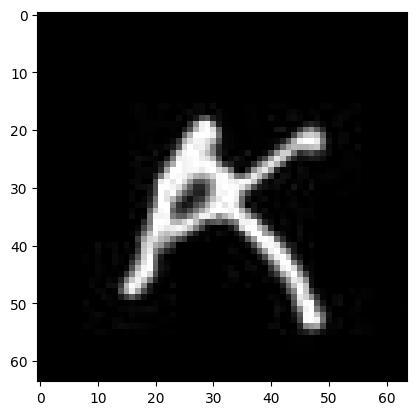

kappa


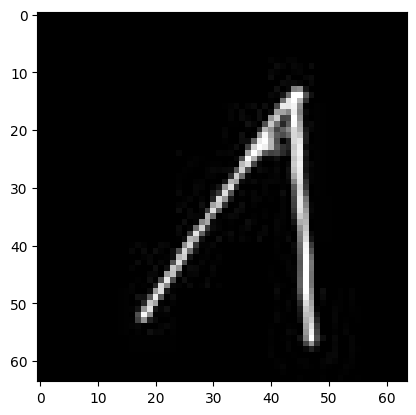

Lambda


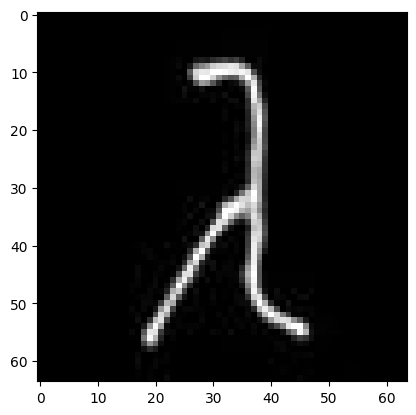

lambda


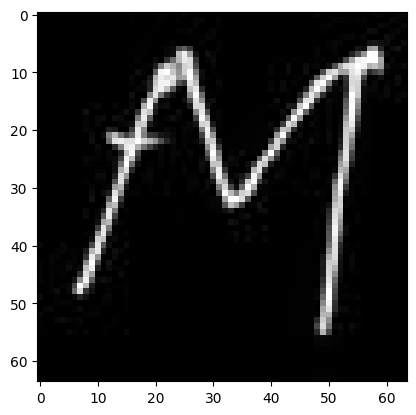

Nu


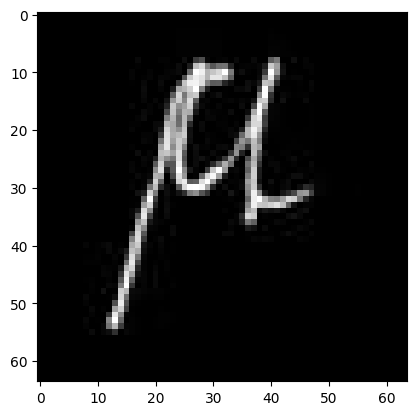

mu


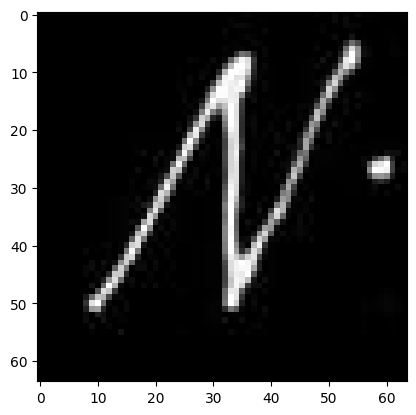

Nu


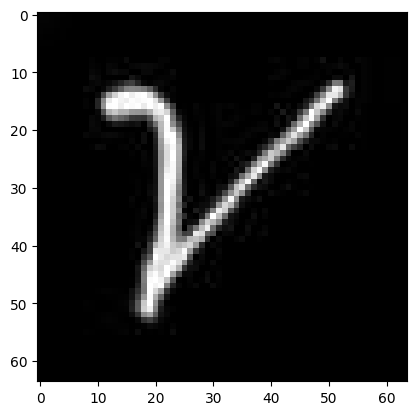

nu


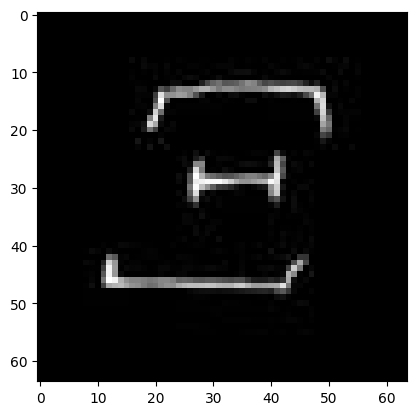

Xi


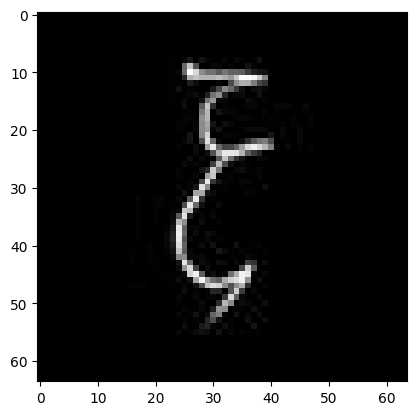

zeta


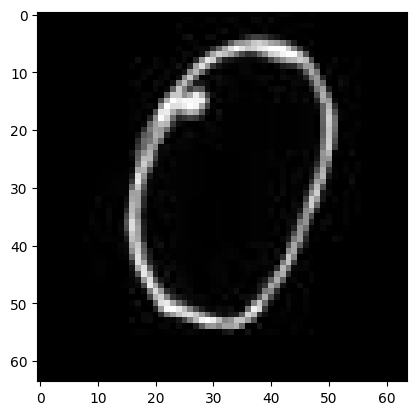

Omicron


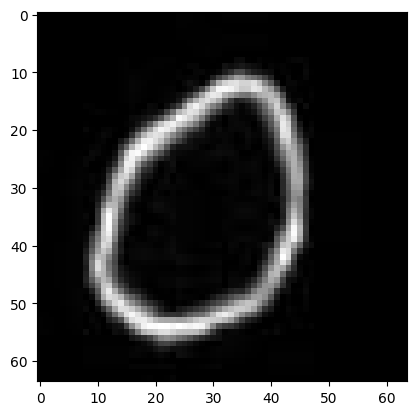

phi


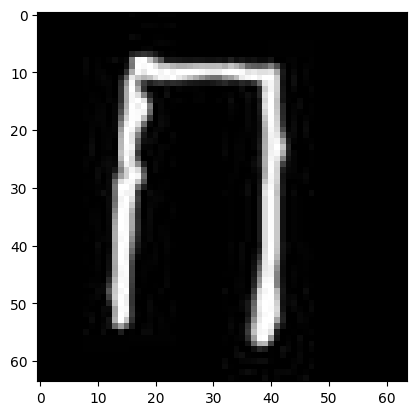

Pi


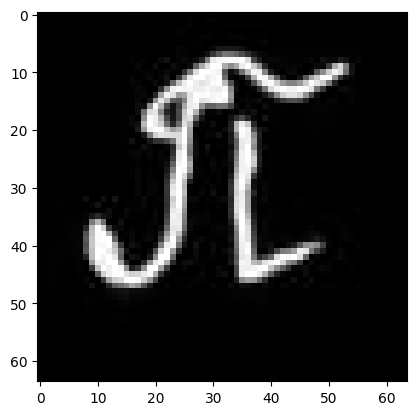

upsilon


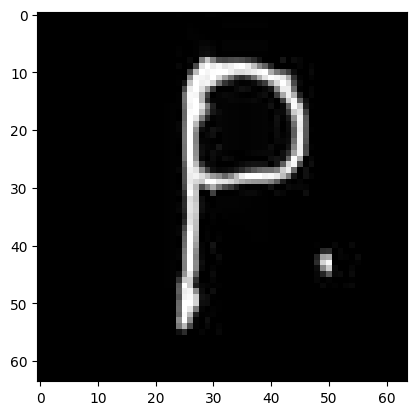

Rho


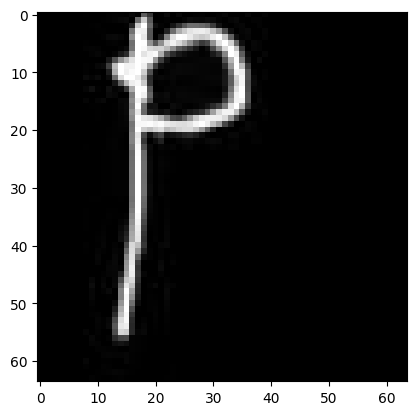

Beta


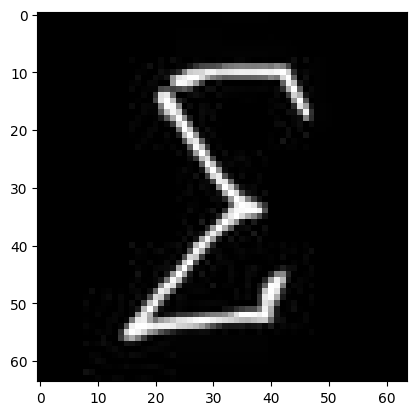

Sigma


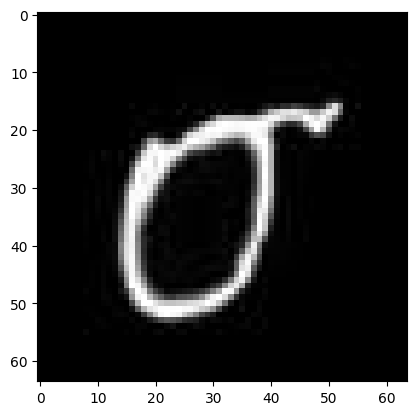

omicron


In [ ]:
# choose a picture at random
d = 100
idx=100
im=test_data[idx:idx+d]

answer = test_labels[idx:idx+d]

# print(answer)

# send to device, rescale, and view as a batch of 1 
im = im.to(device)

# feed it to the net and display the confidence scores
scores =  net(im.unsqueeze(dim=1))
probs= F.softmax(scores, dim=1).cpu()


print(sum(answer == torch.argmax(probs, dim=1)) / d)

# diplay the picture
for i in range(d):
    utils.show(im[i].cpu())
    print(label[torch.argmax(probs[i])])
